In [1]:
import requests
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.9) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


We can avoid scraping the website Immobiliare.it just by using their API (https://www.immobiliare.it/api-next/search-list/real-estates).

If at any time this API should not work, I suggest finding the new one and using a tool like Insomnia to get the Request code. This API can be found on Immobiliare.it by going through the "Network" tab after inspecting the page.

I searched for houses located in Milan but you can change the request very easily just by changing the query on Insomnia.

The json file returns many information about a specific house, for the pourose of this project we'll just need:

-ID
-LUXURY (to know if a house is considered luxurious)
-PRICE 
-NUMBER OF BATHROOMS
-NUMBER OF ROOMS
-SURFACE AREA IN SQUARED METERS
-LOCATION

In [2]:
page = 1  
df1 = pd.DataFrame(columns = ['ID', 'luxury','price','bathrooms','rooms','surface','latitude','longitude'])
while True:
    try:
        url = "https://www.immobiliare.it/api-next/search-list/real-estates"

        querystring = {"fkRegione":"lom","idProvincia":"MI","idComune":"8042"
                       ,"idMZona\\[0\\]":"10046","idContratto":"1","idCategoria":"1","__lang":"it"
                       ,"pag":page,"paramsCount":"1","path":"/vendita-case/milano/centro/"}

        payload = ""
        headers = {
            "authority": "www.immobiliare.it",
            "pragma": "no-cache",
            "cache-control": "no-cache",
            "accept": "*/*",
            "sec-gpc": "1",
            "sec-fetch-site": "same-origin",
            "sec-fetch-mode": "cors",
            "sec-fetch-dest": "empty",
            "referer": "https://www.immobiliare.it/vendita-case/milano/centro/?criterio=rilevanza",
            "accept-language": "en-US,en;q=0.9"
        }

        response = requests.request("GET", url, data=payload, headers=headers, params=querystring).json()
        response = response['results']


        for result in response:
            ID = result['realEstate']['id']
            luxury = result['realEstate']['luxury']
            price = result['realEstate']['price']['value']
            for i in result['realEstate']['properties']:
                bathrooms = i['bathrooms']               
                rooms = i['rooms']
                try:
                    surface = i['surface'].split(' ')[0]
                except:
                    surface = None
                try:    
                    latitude = i['location']['latitude']
                    longitude = i['location']['longitude']
                except:
                    latitude = None
                    longitude = None
                

            row = [ID, luxury,price,bathrooms,rooms,surface,latitude,longitude]
            df1.loc[-1] = row
            df1.index = df1.index + 1  # shifting index
            df1 = df1.sort_index()  # sorting by index

        page +=1
        
    except Exception as e: ##the json doesn't specify how many pages it found so we'll stop when we get an error
        if e == 'Expecting value: line 1 column 1 (char 0)': ##expected error we get when there are no more pages to go through
            print('NO MORE PAGES!\nParsed {} pages'.format(page))
        else:
            print(e) ## print the error if we get an unexpected error
        break
   




NO MORE PAGES!
Parsed 81 pages
Expecting value: line 1 column 1 (char 0)


In [3]:
df = df1

Let's analyze the data we have and try to understand if we have to clean it first

In [5]:
df.nunique()

ID           1994
luxury          2
price         557
bathrooms       5
rooms           7
surface       241
latitude      872
longitude    1080
dtype: int64

In [6]:
df.isnull().nunique()  ##let's drop any column that has null values
df = df.dropna()

In [7]:
df['luxury'] = df['luxury'].astype('bool')
df['rooms'] = df['rooms'].astype('category')
df['bathrooms'] = df['bathrooms'].astype('category')
df['surface'] = df['surface'].astype('float')
df['price'] = df['price'].astype('float')

<ipython-input-7-59cdf1ecfbcb>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['luxury'] = df['luxury'].astype('bool')
<ipython-input-7-59cdf1ecfbcb>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['rooms'] = df['rooms'].astype('category')
<ipython-input-7-59cdf1ecfbcb>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stabl

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1882 entries, 0 to 1997
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   ID         1882 non-null   object  
 1   luxury     1882 non-null   bool    
 2   price      1882 non-null   float64 
 3   bathrooms  1882 non-null   category
 4   rooms      1882 non-null   category
 5   surface    1882 non-null   float64 
 6   latitude   1882 non-null   float64 
 7   longitude  1882 non-null   float64 
dtypes: bool(1), category(2), float64(4), object(1)
memory usage: 94.3+ KB


the "describe" method gives us an overview on how values are distributed across our dataframe

In [9]:
df.describe()

,price,surface,latitude,longitude
count,1.882000e+03,1882.000000,1882.000000,1882.000000
mean,5.372615e+05,96.714134,45.474439,9.183019
std,6.848423e+05,71.812225,0.023453,0.036232
min,4.500000e+03,1.500000,45.402200,9.061900
25%,2.300000e+05,56.000000,45.455650,9.156500
50%,3.550000e+05,80.000000,45.475300,9.183800
75%,5.800000e+05,110.000000,45.493158,9.211100
max,1.200000e+07,967.000000,45.529800,9.266100


In [10]:
df.head()

,ID,luxury,price,bathrooms,rooms,surface,latitude,longitude
0,94539010,False,138750.0,0,2,43.0,45.449131,9.179613
1,94537710,False,450000.0,1,3,90.0,45.490000,9.183500
2,94529298,False,53147.0,1,4,53.0,45.470699,9.138344
3,94537504,False,185000.0,1,3,70.0,45.497600,9.150800
4,94529252,False,34500.0,1,2,38.0,45.466831,9.093323


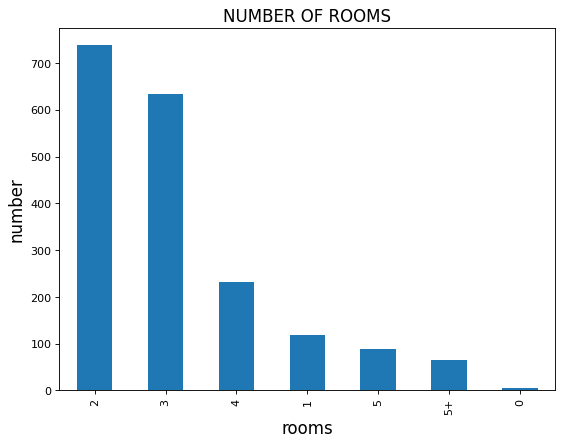

In [11]:
plt.figure(figsize=(8, 6), dpi=80)

df['rooms'].value_counts().plot(kind = 'bar')
plt.title('NUMBER OF ROOMS', fontsize = 15)
plt.xlabel('rooms', fontsize = 15)
plt.ylabel('number', fontsize = 15)

plt.show()

the biggest number of houses sold in Milan have 2/3 rooms, while few are the ones with 5 or more rooms 

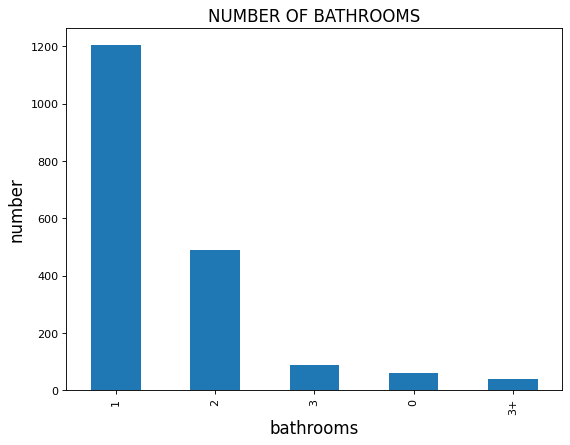

In [12]:
plt.figure(figsize=(8, 6), dpi=80)

df['bathrooms'].value_counts().plot(kind = 'bar')
plt.title('NUMBER OF BATHROOMS', fontsize = 15)
plt.xlabel('bathrooms', fontsize = 15)
plt.ylabel('number', fontsize = 15)

plt.show()

most of the houses sold in Milan have 1 bathroom, while few are the one with 3 or more

/home/ale/.local/lib/python3.8/site-packages/seaborn/axisgrid.py:2073: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


<Figure size 640x480 with 0 Axes>

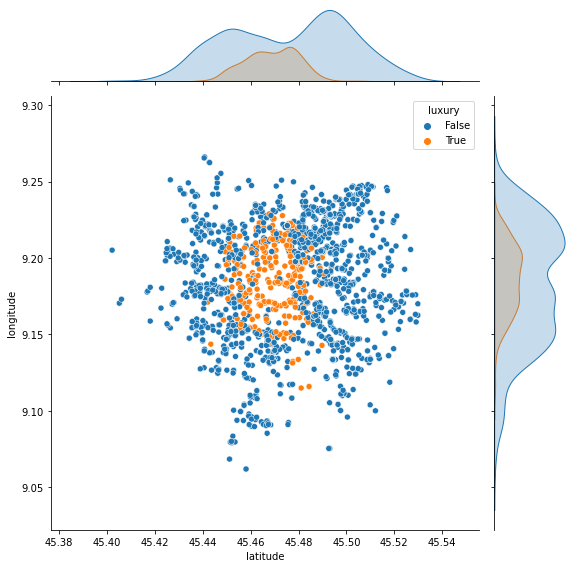

In [13]:
plt.figure(figsize=(8, 6), dpi=80)

sns.jointplot(x = df['latitude'], y = df['longitude'], size = 8, hue = df['luxury'])
plt.xlabel('latitude', fontsize = 15)
plt.ylabel('longitude', fontsize = 15)
plt.show()

As we can see from the geographical distribution of the houses on sale in the city of Milan, most houses are located in the northern part of the city. Few are the ones in the south. Luxury houses seem to be located more in the center of the city.

It would be interesting to understand if the houses in the north are being sold because people want to get rid of them (perhaps because they expect their value to decrease in the immidiate future) or because the demand for houses located in this part of the city is  particularly high and the residents are more willing to sell now given the high returns they will get.

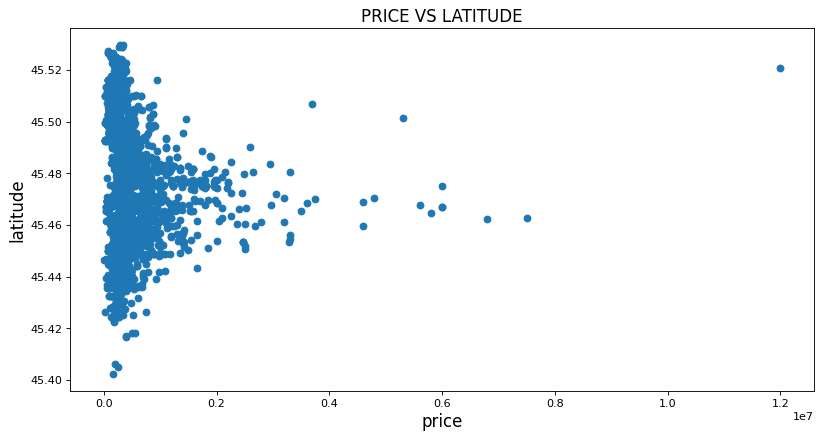

In [14]:
plt.figure(figsize=(12, 6), dpi=80)
plt.title('PRICE VS LATITUDE', fontsize = 15)
plt.scatter(df['price'],df['latitude'])
plt.xlabel('price', fontsize = 15)
plt.ylabel('latitude', fontsize = 15)
plt.show()

Seems like the houses in the center of the city sell at a higher price than houses more on the outskirts of the city

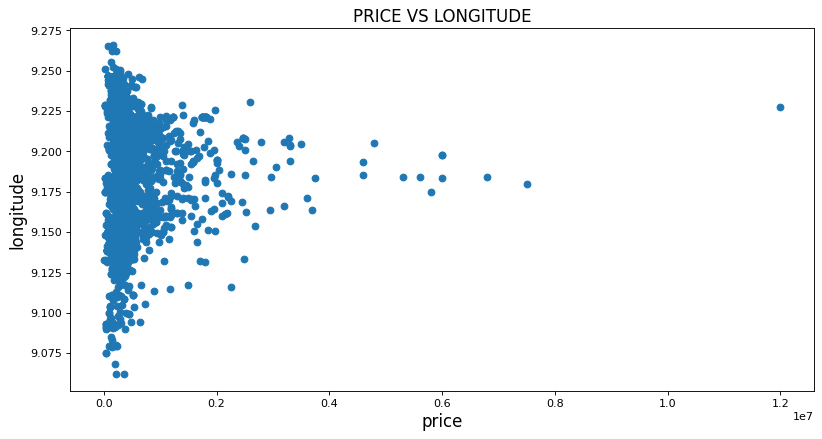

In [15]:
plt.figure(figsize=(12, 6), dpi=80)
plt.title('PRICE VS LONGITUDE', fontsize = 15)
plt.scatter(df['price'],df['longitude'])
plt.xlabel('price', fontsize = 15)
plt.ylabel('longitude', fontsize = 15)
plt.show()

As we observed before, the houses on the northern part of the city seem to sell at a higher price. This probably means that the houses in this area are more requested (newer houses? better position? etc.)

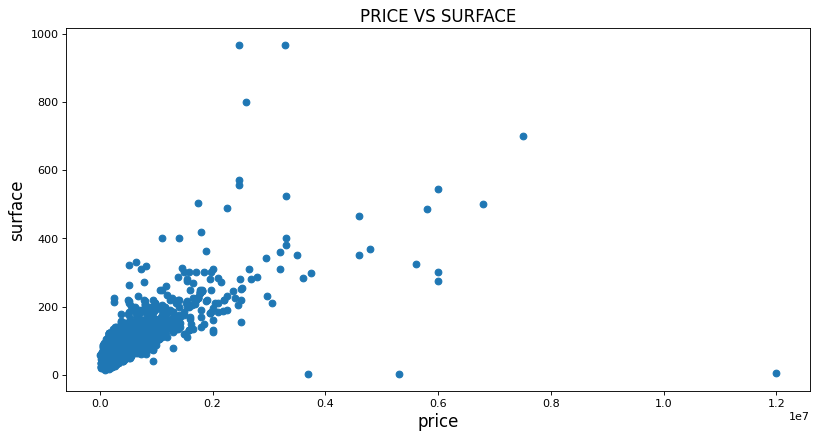

In [16]:
plt.figure(figsize=(12, 6), dpi=80)
plt.title('PRICE VS SURFACE', fontsize = 15)
plt.scatter(df['price'],df['surface'])
plt.xlabel('price', fontsize = 15)
plt.ylabel('surface', fontsize = 15)
plt.show()

as we can expect, lower surface area means that sellers will ask for a lower price for their house

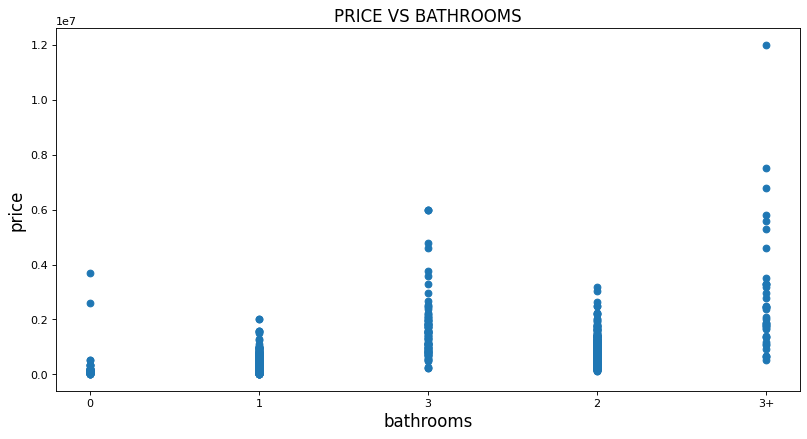

In [17]:
plt.figure(figsize=(12, 6), dpi=80)
plt.title('PRICE VS BATHROOMS', fontsize = 15)
plt.scatter(df['bathrooms'],df['price'])
plt.xlabel('bathrooms', fontsize = 15)
plt.ylabel('price', fontsize = 15)
plt.show()

the more bathrooms there are in a house, the higher the selling price

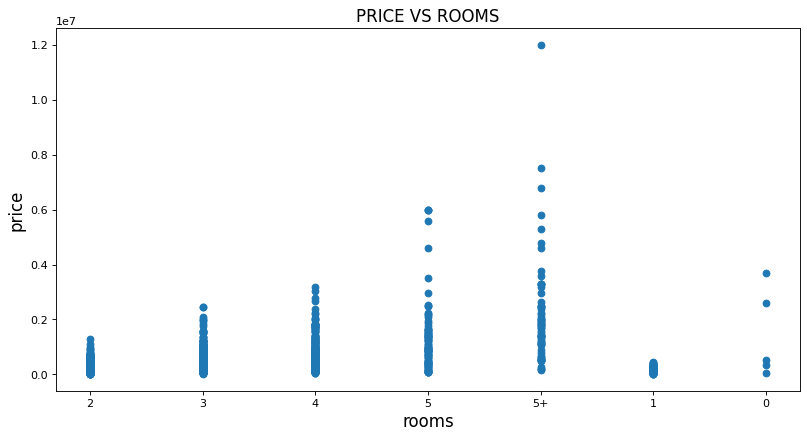

In [18]:
plt.figure(figsize=(12, 6), dpi=80)
plt.title('PRICE VS ROOMS', fontsize = 15)
plt.scatter(df['rooms'],df['price'])
plt.xlabel('rooms', fontsize = 15)
plt.ylabel('price', fontsize = 15)
plt.show()

the more rooms there are in a house, the higher the selling price

# LINEAR REGRESSION

Let's see if we can find a good regression model to try and predict house prices based on the features we managed to scrape

In [82]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

The "bathrooms" and "rooms" columns are objects. We need to convert the strings we have in these columns to integers.

In [83]:
model = LinearRegression()
conv_rooms = [6 if value == '5+' else value for value in df['rooms']]
conv_bathrooms = [4 if value == '3+' else value for value in df['bathrooms']]

In [84]:
X = df

In [85]:
X['conv_rooms'] = conv_rooms
X['conv_bathrooms'] = conv_bathrooms
y = X['price']
X = X.drop(['ID','price','bathrooms','rooms'], axis = 1)

<ipython-input-85-93ea96e31a1c>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['conv_rooms'] = conv_rooms
<ipython-input-85-93ea96e31a1c>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['conv_bathrooms'] = conv_bathrooms


In [141]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state=2)

In [92]:
model.fit(X_train, y_train)

LinearRegression()

In [93]:
model.score(X_train, y_train)

0.6515812087774397

Linear Regression doesn't have a very good accuracy. Let's try with some other model and attempt to get a better result 

## GRADIENT BOOST REGRESSION

In [95]:
from sklearn import ensemble

In [110]:
model = ensemble.GradientBoostingRegressor(n_estimators=400,max_depth=5,min_samples_split=2,
                                           learning_rate=0.1, loss='squared_error')

In [111]:
model.fit(X_train,y_train)

GradientBoostingRegressor(max_depth=5, n_estimators=400)

In [112]:
model.score(X_train,y_train)

0.998910153550921

Gradient Boosting Regression has, as expected, a very high accuracy. Let's confront it with Random Forest Regression to see if the results are similiar

# RANDOM FOREST

In [122]:
from sklearn.ensemble import RandomForestRegressor

In [123]:
model = RandomForestRegressor(n_estimators = 1000, random_state = 42)

In [124]:
model.fit(X_train,y_train)

RandomForestRegressor(n_estimators=1000, random_state=42)

In [127]:
model.score(X_train,y_train)

0.9774072305264508

The score for Random Forest is similiar to the one of Gradient Boosting Regressor but not quite as high.